In [1]:
%pip install dask_gateway
# %pip install thermofeel
# %pip install xclim
# %pip install pygmt

  Using cached dask_gateway-2023.1.1-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import s3fs
import numpy as np
import dask
import xclim
import xarray as xr
import dask
from dask.distributed import Client
from dask_gateway import Gateway
import pandas as pd
import cf_xarray
import sys
from cmip6_downscaling.data.utils import lon_to_180
import matplotlib.pyplot as plt

In [2]:
client = Client(threads_per_worker=1, n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/orianac/proxy/8787/status,
Dashboard: /user/orianac/proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 248.96 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38335,Workers: 8
Dashboard: /user/orianac/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 248.96 GiB
Comm: tcp://127.0.0.1:40547,Total threads: 1
Dashboard: /user/orianac/proxy/37197/status,Memory: 31.12 GiB
Nanny: tcp://127.0.0.1:35087,


In [3]:
def find_nasanex_filename(nasa_nex_runs_df, gcm, scenario):
    '''
    TODO: docstring
    '''
    template_filename = nasa_nex_runs_df[(nasa_nex_runs_df['GCM']==gcm)&\
                     (nasa_nex_runs_df['scenario']==scenario)&\
                     (nasa_nex_runs_df['variable']=='tasmax')]['file_name'].iloc[0]
    _variable, _timestep, _gcm, _scenario, ensemble_member, grid_code, _yearnc = template_filename.split('_')
    return ensemble_member, grid_code

In [4]:
def load_nasanex(scenario, gcm, variables, years, nasanex_df):
    '''
    TODO: docstring
    '''
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)

    file_objs = {}
    ds_dict = {}
    ds = xr.Dataset()
    ensemble_member, grid_code = find_nasanex_filename(nasanex_df, gcm, scenario)
    for var in variables: 
        file_objs[var] = [fs.open(f'nex-gddp-cmip6/NEX-GDDP-CMIP6/{gcm}/{scenario}/{ensemble_member}/{var}/{var}_day_{gcm}_{scenario}_{ensemble_member}_{grid_code}_{year}.nc') for year in years]
        ds[var] = xr.open_mfdataset(file_objs[var], engine='h5netcdf')[var]
    ds = ds.chunk({'time': 40})
    ds = ds.persist()
    return ds

In [5]:
df = pd.read_csv('gddp-cmip6-files.csv')
nasa_nex_runs = pd.DataFrame([run.split('/') for run in df[' fileURL'].values]).drop([0,1,2,3], axis=1)
nasa_nex_runs.columns = ['GCM', 'scenario', 'ensemble_member', 'variable', 'file_name']

In [45]:
# Find corn heat units
# per https://canterra.com/blog/corn-seed/calculating-chu-gdd-in-corn/
# FUN FACT: It takes approximately 150-180 CHU’s for a corn seedling to germinate and emerge.
# corn needs ~2500 gdu per https://agrigold.com/agronomy/crop-growth-development/heat-units-and-corn-maturity/
NECESSARY_HEAT_UNITS = 2500
# corn needs greater than 25 inches of precipitation. we'll just do an annual sum
# and assume that they can store the rain
NECESSARY_PRECIPITATION = 25 * 25.4 / 86400 # kg /m**2 s 

In [46]:
scenario_years = {'historical':np.arange(1970,2015),
                  'ssp370': np.arange(2015,2099)}

In [47]:
def calculate_dryspell_metrics(ds, year, dryspell_length=14):
    # 1.0 mm/day is the default value for the xclim implementation's determination of a dry day
    # calculate the daily corn units
    corn_units = xclim.indicators.atmos.corn_heat_units(ds=ds)#.groupby('time.year')#.sum()

    # find out WHEN the corn units are over a certain threshold
    warm_enough = (corn_units.sum(dim='time') > NECESSARY_HEAT_UNITS)
    wet_enough = (ds.pr.sum(dim='time')>NECESSARY_PRECIPITATION)
    results = xclim.indicators.atmos.dry_spell_total_length(ds=ds, 
                                                               window=dryspell_length,
                                                              ).rename({'time': 'year'})
    results = results.assign_coords({'year': [pd.to_datetime(year, format='%Y')]}).astype('float')
    results = results.to_dataset(name='dry_spell_days').astype('float32')
    
    results['dry_spell_days'].attrs['units'] = 'number_of_days'

    no_dry_spells_mask = results['dry_spell_days']<14
    
    # CornEnergy is the corn heat units everywhere in the world
    results['CornEnergy'] = corn_units.groupby('time.year').sum().assign_coords({'year': [pd.to_datetime(year, format='%Y')]})
    # CornPossible is CornEnergy in parts of the world where there are enough annual corn heat units AND enough annual precipitation to support corn assuming
    # dryland agriculture
    # This does not account for thermal stresses due to high temperatures
    # as outlined in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7913793/
    print(results['CornEnergy'])
    print(warm_enough)
    print(wet_enough)
    results['CornPossible'] = results['CornEnergy'].where(warm_enough).where(wet_enough)
    results['CornPossible_binary'] = (results['CornPossible'] > -9999)
    # CornSafe masks CornPossible to only regions free from dry spells longer than 14 days. 
    # We stress that this scaling does not account for simultaneity
    # (aka the dryspells could occur outside of the growing season and thus be functionally irrelevant but would
    # still be included here)
    print(results['CornPossible'])
    results['CornSafe'] = results['CornPossible'].where(no_dry_spells_mask).assign_coords({'year': [pd.to_datetime(year, format='%Y')]})
    results['CornSafe_binary'] = (results['CornSafe'] > -9999)
    # DrySpellFraction is the fraction of the year that is involved in dry spells longer than the specified
    # dryspell_length (default is 14 days)
    results['DrySpellFraction'] = (365-results['dry_spell_days'])/365
    # CornLikely scales CornPossible by the DrySpellFraction to diminish the CornPossible according to how much
    # of the year is involved in dry spells. This is a less stringent version than CornSafe, which excludes any region
    # that has any dry spell longer than 14 days.
    results['CornLikely'] = results['CornPossible']*results['DrySpellFraction']
    # We choose an arbitrary threshold for this new CornLikely of 2500 to determine where 
    # corn will likely have enough energy to grow but not be impeded substantially by dry spells
    results['CornLikely_binary'] = results['CornLikely'] > 2500
    results.lat.attrs['standard_name'] = 'latitude'
    results.lon.attrs['standard_name'] = 'longitude'
    results = results.rename({'year': 'time'})
    results.time.attrs['standard_name'] = 'time'
    return results

In [ ]:
gcm = 'CanESM5'

for scenario, years in scenario_years.items():
    id_string = f"{gcm}-{scenario}"
    dsets = []

    output = f"s3://carbonplan-data-viewer/demo/dryspells_corn/{id_string}-multivar.zarr"
    for year in years: 
        ds = load_nasanex(gcm=gcm, scenario=scenario,
                          variables=['tasmax', 'pr', 'tasmin'], 
                          years=[year], nasanex_df=nasa_nex_runs)
        out_ds = calculate_dryspell_metrics(ds, year)
        dsets.append(out_ds)
    dset = xr.concat(dsets, dim='time')
    dset = dask.optimize(dset)[0]
    dset.to_zarr(output, consolidated=True, mode='w')

<xarray.DataArray 'CornEnergy' (year: 1, lat: 600, lon: 1440)>
dask.array<stack, shape=(1, 600, 1440), dtype=float32, chunksize=(1, 600, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * year     (year) datetime64[ns] 1970-01-01
Attributes:
    units:          
    standard_name:  air_temperature
    cell_measures:  area: areacella
    original_name:  STMX
    cell_methods:   tasmin: area: mean time: minimum tasmax: area: mean time:...
    history:        tasmin: \ntasmax: \n[2023-04-20 00:42:23] chu: CORN_HEAT_...
    long_name:      Corn heat units (tmin > 4.44 degc and tmax > 10 degc)
    description:    Temperature-based index used to estimate the development ...
<xarray.DataArray 'chu' (lat: 600, lon: 1440)>
dask.array<gt, shape=(600, 1440), dtype=bool, chunksize=(600, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (l

In [36]:
dset = xr.open_zarr(output)

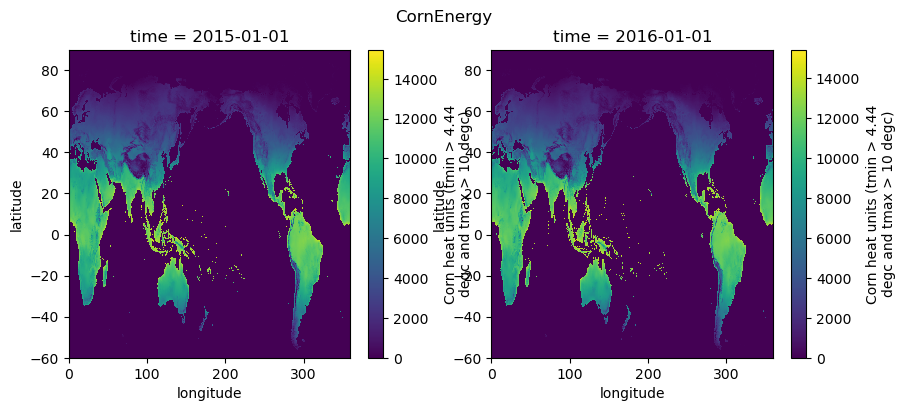

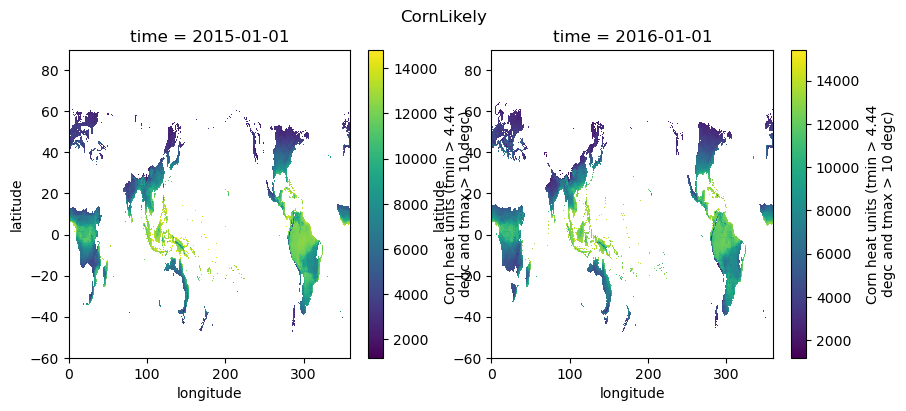

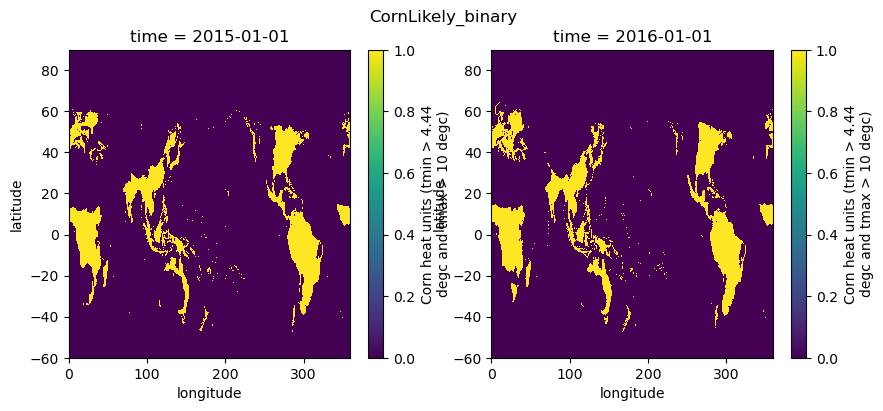

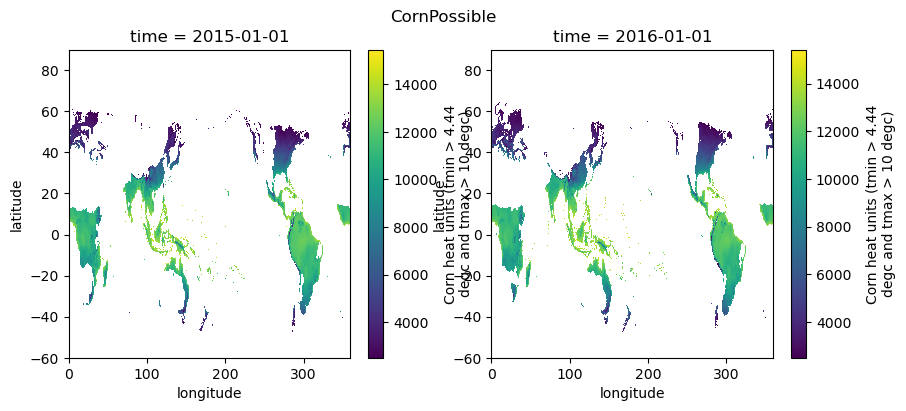

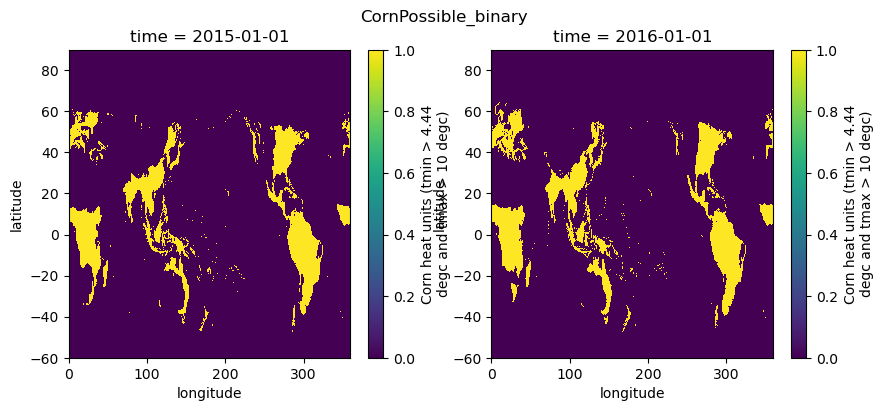

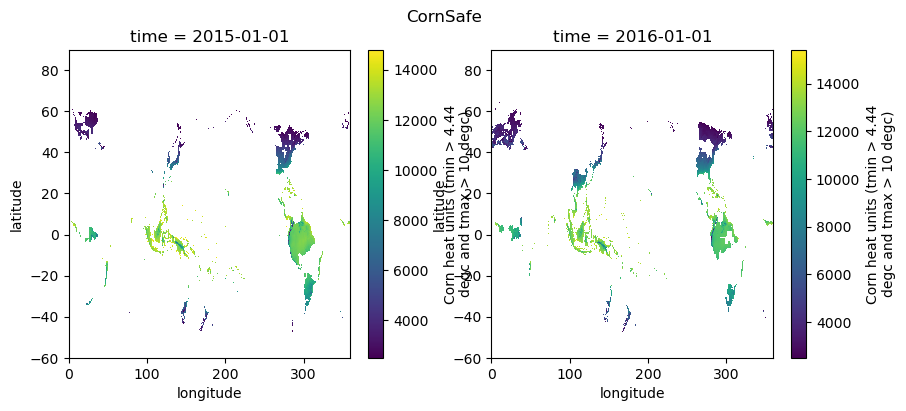

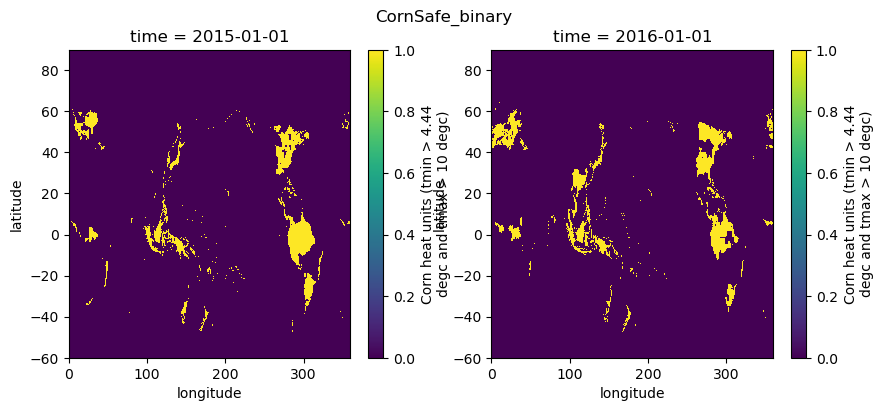

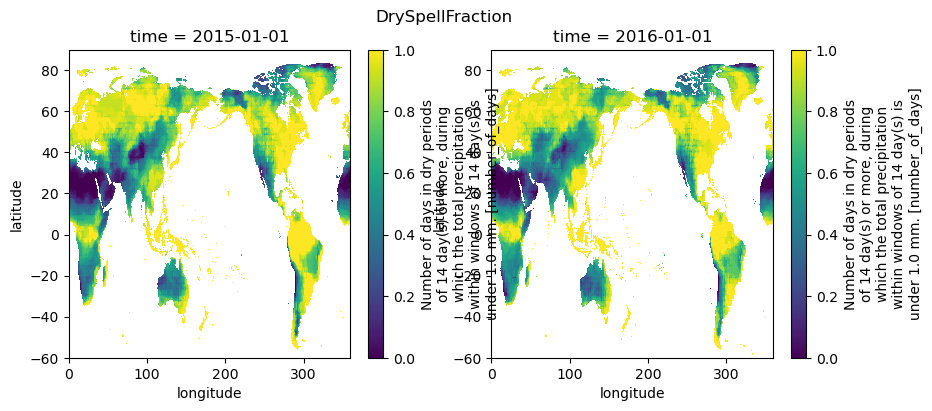

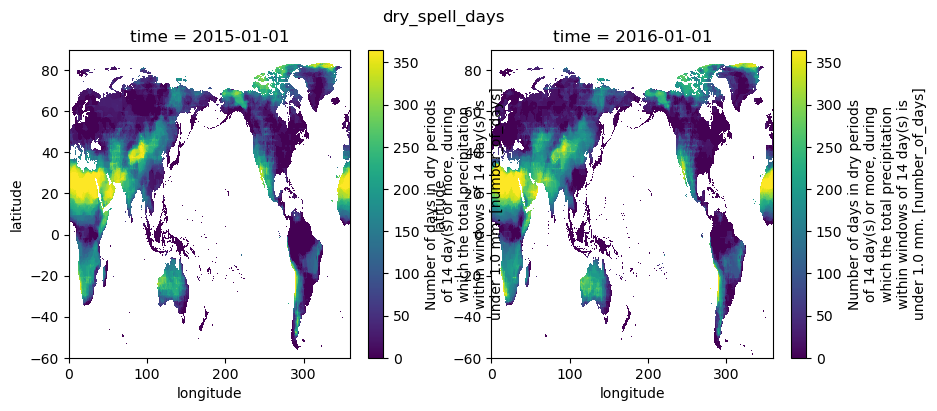

In [44]:
for var in dset.isel(time=0):
    fig, axarr = plt.subplots(1,2, figsize=(10,4))
    dset.isel(time=0)[var].plot(ax=axarr[0])
    dset.isel(time=1)[var].plot(ax=axarr[1])
    fig.suptitle(var)

In [24]:
test = xclim.indicators.atmos.dry_spell_total_length(ds=ds, 
                                                   window=7,
                                                     
                                                  ).rename({'time': 'year'}).astype('float32')

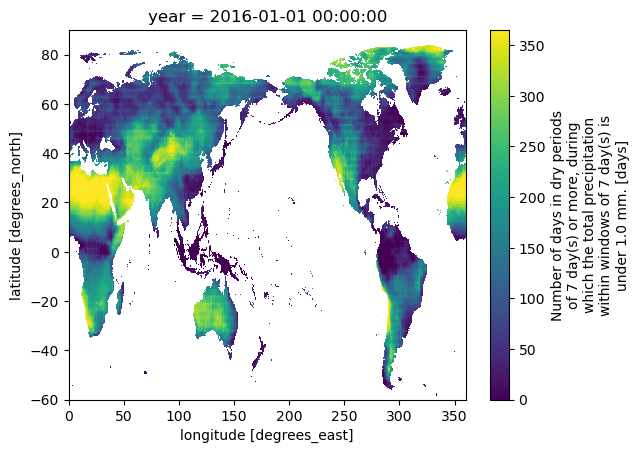

In [20]:
test.plot()

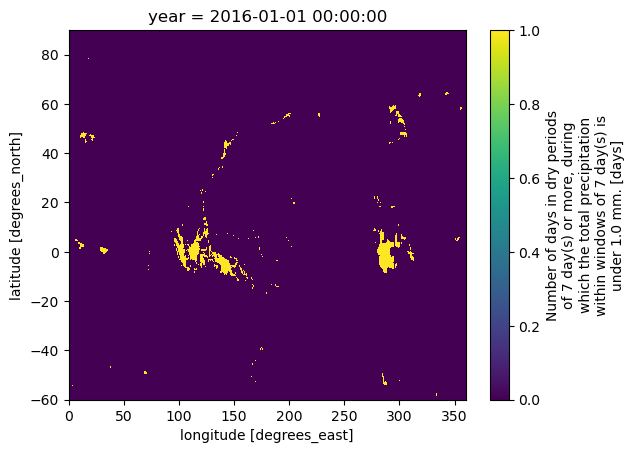

In [26]:
(test<7).plot()

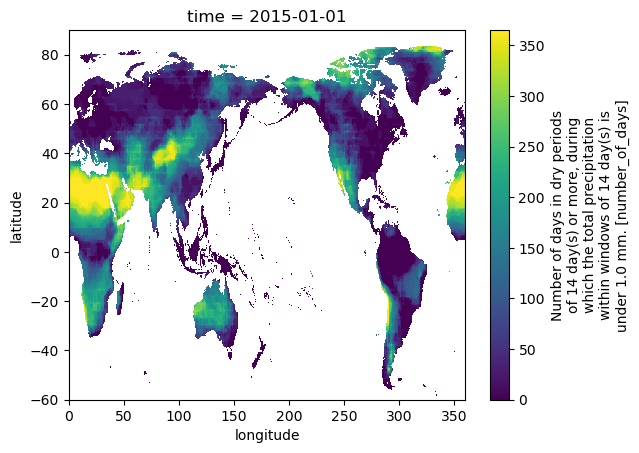

In [17]:
dset = xr.open_zarr('s3://carbonplan-data-viewer/demo/dryspells_corn/CanESM5-ssp370-multivar.zarr')
dset['dry_spell_days'].isel(time=0).plot()

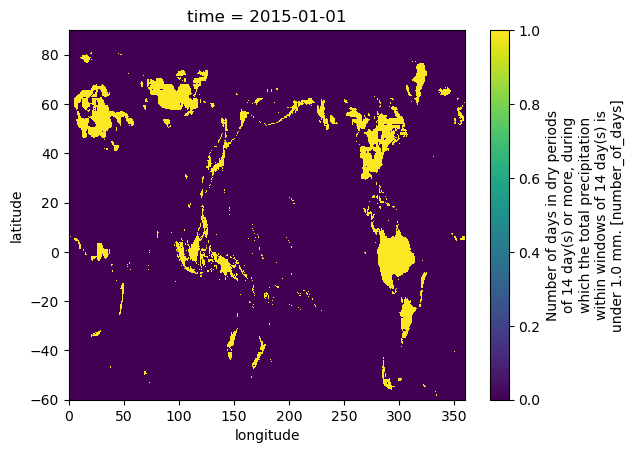

In [29]:
(dset['dry_spell_days'].isel(time=0)<14).plot()

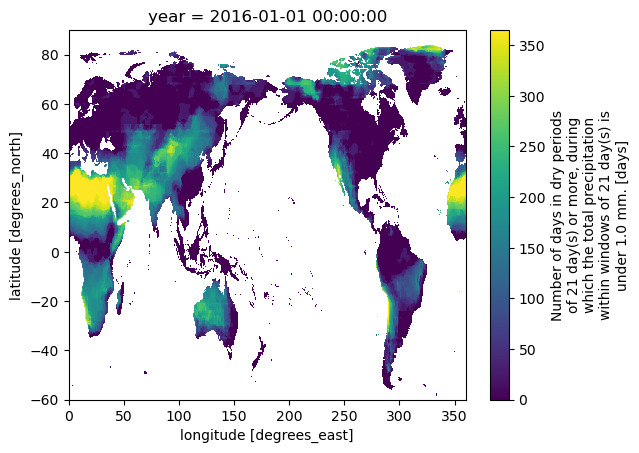

In [30]:
test = xclim.indicators.atmos.dry_spell_total_length(ds=ds, 
                                                   window=21,
                                                  ).rename({'time': 'year'}).astype('float32')
test.plot()

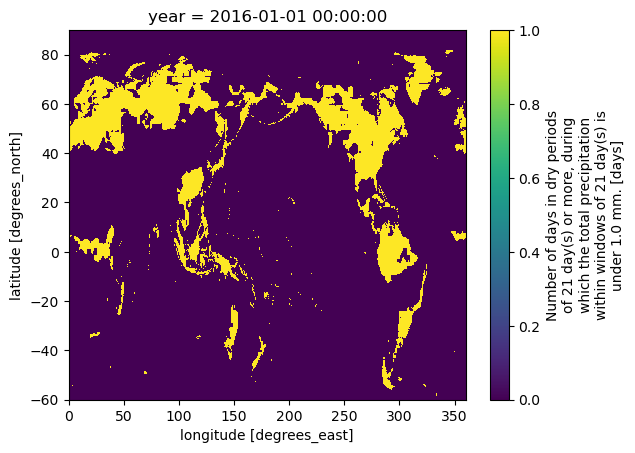

In [31]:
(test<21).plot()

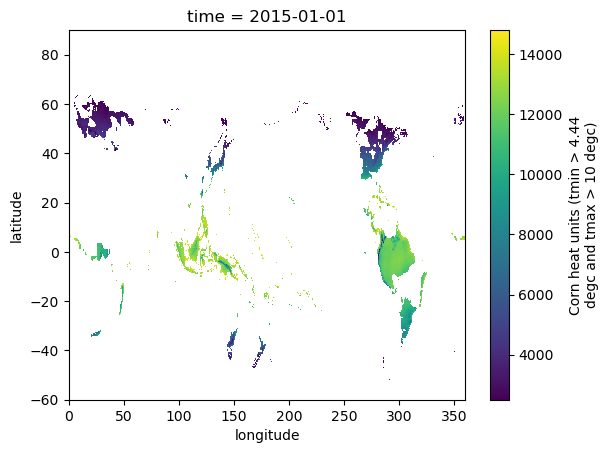

In [13]:
dset['CornSafe'].isel(time=0).plot()

In [11]:
for timeframe, year in year_dict.items():
    dry_adjusted = (out_ds_dict[timeframe]['CornPossible']*((365-out_ds_dict[timeframe]['dry_spell_days'])/365))
    safe_enough = (dry_adjusted > 2500)
    out_ds_dict[timeframe]['dryspell_adjusted'] = dry_adjusted.where(safe_enough).compute()
    out_ds_dict[timeframe]['dryspell_adjusted_annual_adjusted'] = dry_adjusted.where(safe_enough).where(ds_dict[timeframe].pr.sum(dim='time')>NECESSARY_PRECIPITATION)

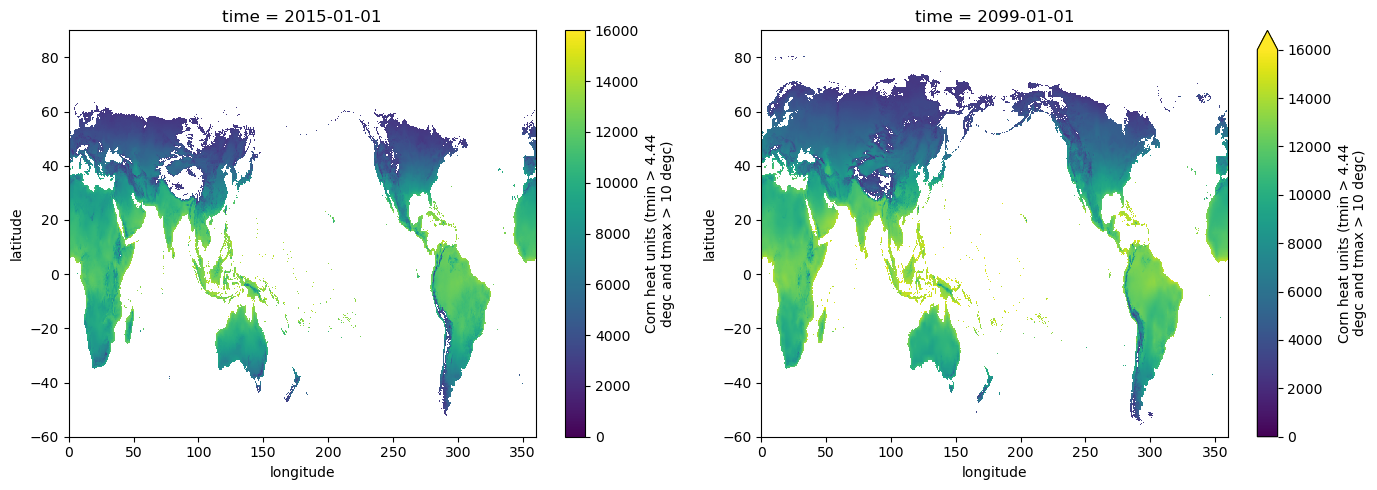

In [18]:
fig, axarr = plt.subplots(ncols=2, figsize=(14,5))
for col, timeframe in enumerate(out_ds_dict.keys()):
    out_ds_dict[timeframe]['CornPossible'].plot(ax=axarr[col], vmin=0, vmax=16000)
plt.tight_layout()

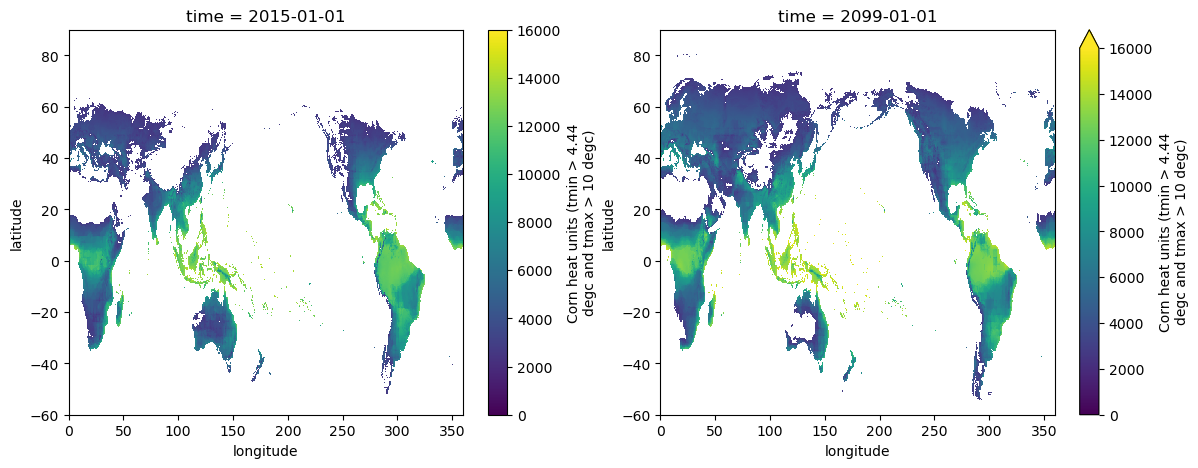

In [19]:
fig, axarr = plt.subplots(ncols=2, figsize=(14,5))
for col, timeframe in enumerate(out_ds_dict.keys()):
    out_ds_dict[timeframe]['dryspell_adjusted'].plot(ax=axarr[col], vmin=0, vmax=16000)

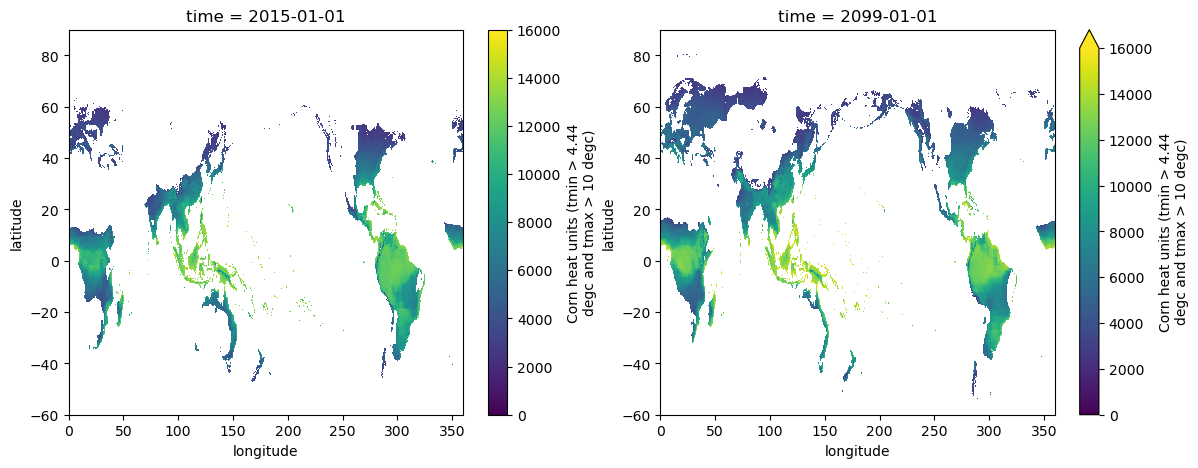

In [21]:
fig, axarr = plt.subplots(ncols=2, figsize=(14,5))
for col, timeframe in enumerate(out_ds_dict.keys()):
    out_ds_dict[timeframe]['dryspell_adjusted_annual_adjusted'].plot(ax=axarr[col], vmin=0, vmax=16000)

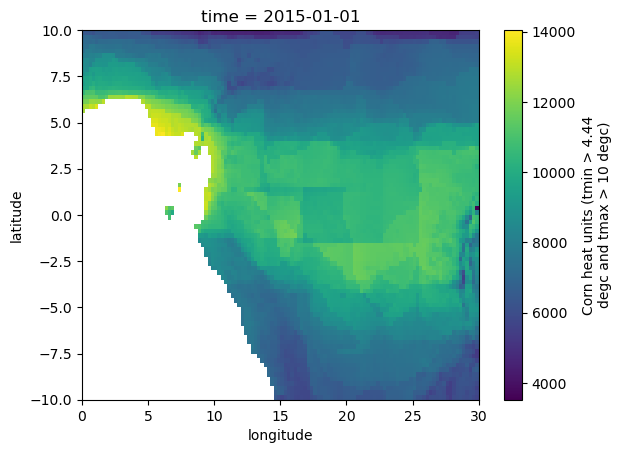

In [22]:
out_ds_dict['hist']['dryspell_adjusted_annual_adjusted'].sel(lat=slice(-10, 10), lon=slice(0,30)).plot()

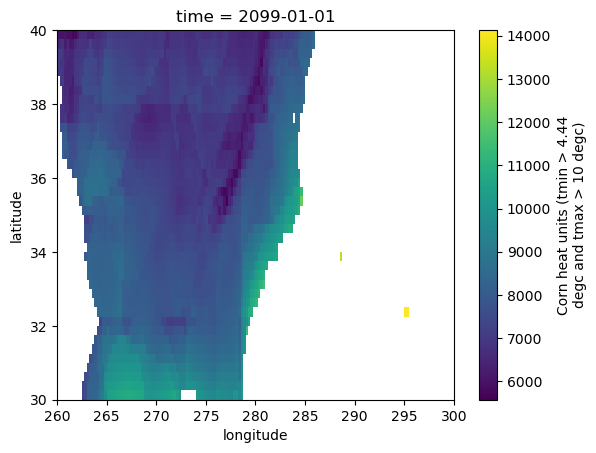

In [25]:
out_ds_dict['fut']['dryspell_adjusted_annual_adjusted'].sel(lat=slice(30, 40), lon=slice(260,300)).plot()

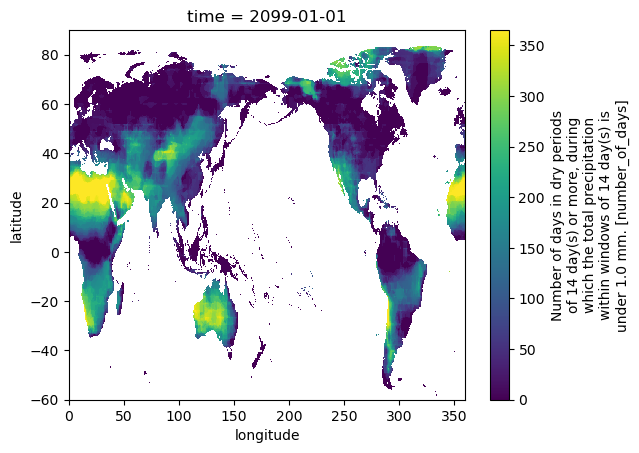

In [54]:
fut_ds['dry_spell_days'].plot()

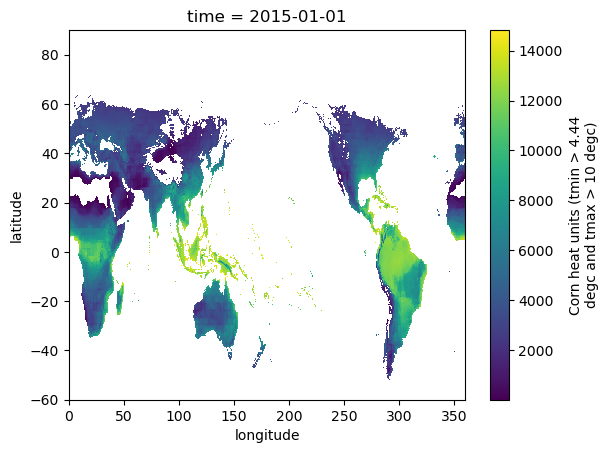

In [74]:
dry_adjusted = (out_ds['CornPossible']*((365-out_ds['dry_spell_days'])/365))
safe_enough = (dry_adjusted > 0)
dry_adjusted.where(safe_enough).plot(vmin=0, vmax=15000)

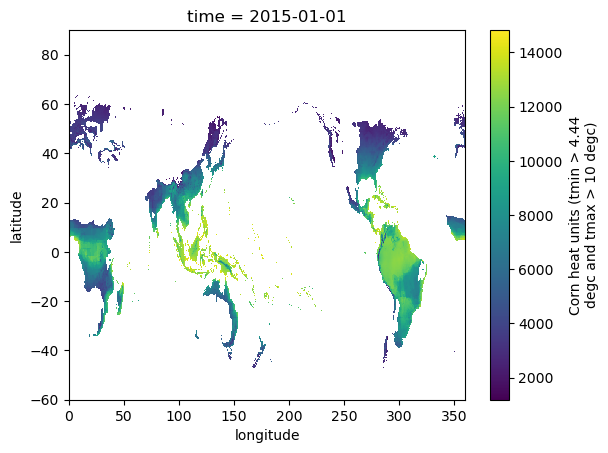

In [76]:
dry_adjusted.where(safe_enough).where(ds.pr.sum(dim='time')>NECESSARY_PRECIPITATION).plot()

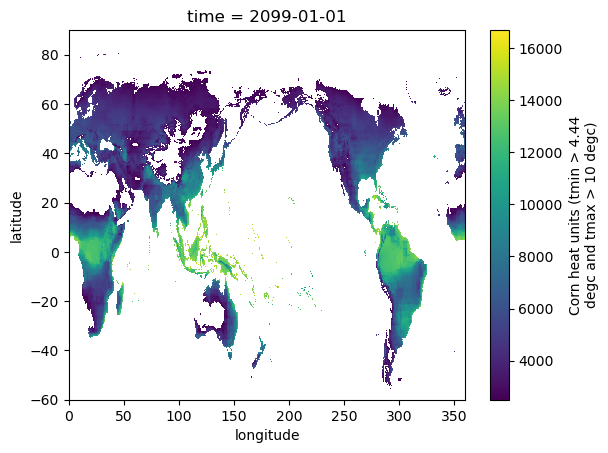

In [79]:
dry_adjusted = (out_ds['CornPossible']*((365-out_ds['dry_spell_days'])/365))
safe_enough = (dry_adjusted > 2500)
dry_adjusted.where(safe_enough).plot()

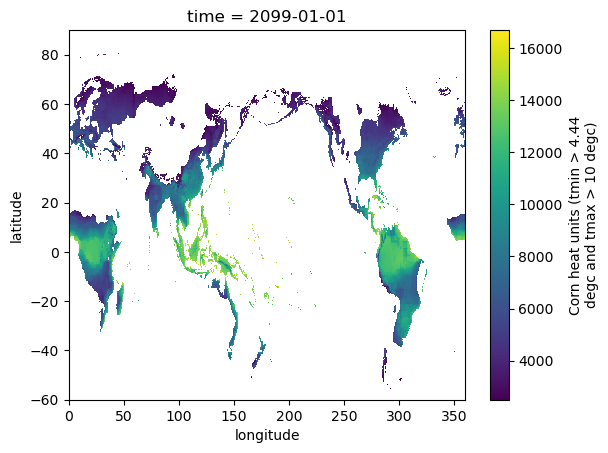

In [80]:
dry_adjusted.where(safe_enough).where(ds.pr.sum(dim='time')>NECESSARY_PRECIPITATION).plot()

Tricky things:
* One of the big caveats of this analysis is that I don't exclude places based on them being _too_ hot. As a result, it's more like the too hot places are excluded by disregrading the yellow ends of the colorbar. Once we add in the idea of dryspells as a factor modulating the CornPossible, it makes for weird areas to pop up like the spot at (15N, 0E). It's really hot but also really dry. We can correct for that a bit by adding in another threshold about annual precipitation. This makes for a more sensible map but it does mask out areas in a way that perhaps you don't want. I think it makes more sense though. Imagine someone looking at the map and critiquing "wait, we can't grow corn in the Sahara!"
* 